In [1]:
#Importação bibliotecas e configuração dispositivo
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda'
import cv2, glob, pandas as pd
%matplotlib inline
from glob import glob

In [2]:
#Extraindo os dados de treino e teste
train_data_dir = 'archive/training_set/training_set'
test_data_dir = 'archive/test_set/test_set'

In [3]:
from torch.utils.data import Dataset, DataLoader
class cats_dogs(Dataset):
    def __init__(self, folder): #Construtor
        #Encontra o caminho para gatos e cachorros
        cats = glob(folder + '/cats/*.jpg')
        dogs = glob(folder + '/dogs/*.jpg')
        self.fpaths = cats + dogs #combina as listas
        
        from random import shuffle, seed
        seed(10)
        shuffle(self.fpaths) #Embaralha a lista de caminhos

        #Cria as classes baseadas no arquivo, true para dog e false para gato
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self): #Retorna o tamanho
        return len(self.fpaths)  

    def __getitem__(self, ix): #Retorna uma unica imagem 
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (224, 224))
        im_tensor = torch.tensor(im / 255.).permute(2, 0, 1).float()
        target_tensor = torch.tensor([target]).float()
        return im_tensor, target_tensor

In [4]:
data = cats_dogs(train_data_dir)
im, label = data[200]

tensor([1.])


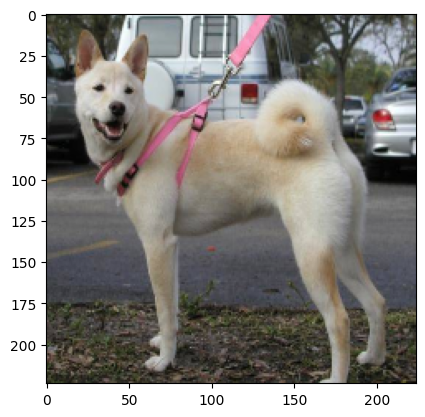

In [5]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)
plt.show()

In [6]:
def get_model():
    def conv_layer(ni, no, kernel_size, stride=1): #Definição da camada de convolução
        return nn.Sequential(
            nn.Conv2d(ni, no, kernel_size, stride),
            nn.ReLU(),
            nn.BatchNorm2d(no),
            nn.MaxPool2d(2)
        )

    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(), #Flatten para normalizar os dados para a camada linear
        nn.Linear(512, 1), # CORREÇÃO FINAL: O tamanho de entrada correto é 512
        nn.Sigmoid() #Função de ativação
    ).to(device)
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

In [7]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [8]:
#Retorna os dados de treino e validação
def get_data(train_path, test_path, batch_size=16):
    train_dataset = cats_dogs(train_path)
    val_dataset = cats_dogs(test_path)
    trn_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return trn_dl, val_dl

In [9]:
#Retorna o erro por batch
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [10]:
@torch.no_grad()
def accuracy(x, y, model): #Retorna uma lista com a acuracia do modelo
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [11]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn): #Retorna o erro do modelo
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()
    

In [ ]:
#Junta tudo para o treinamento
trn_dl, val_dl = get_data(train_data_dir, test_data_dir)
model, loss_fn, optimizer = get_model()

#Listas para salvar o historico
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    
    print(f"--- Época: {epoch+1}/5 ---")

    #Treina os dados
    train_epoch_losses, train_epoch_accuracies = [], []
    for x, y in trn_dl:
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)

    #Calcula a media do erro e da acuracia 
    avg_train_loss = np.mean(train_epoch_losses)
    avg_train_acc = np.mean(train_epoch_accuracies)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    #Faz a validação
    val_epoch_losses, val_epoch_accuracies = [], []
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        val_batch_loss = val_loss(x, y, model, loss_fn)
        val_epoch_losses.append(val_batch_loss)
        is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(is_correct)

    #Calcula a média de acuracia da epoca
    avg_val_loss = np.mean(val_epoch_losses)
    avg_val_acc = np.mean(val_epoch_accuracies)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Perda de Treino: {avg_train_loss:.4f}, Acurácia de Treino: {avg_train_acc:.4f}")
    print(f"Perda de Validação: {avg_val_loss:.4f}, Acurácia de Validação: {avg_val_acc:.4f}")
    print("-" * 30)

--- Época: 1/5 ---


In [ ]:
#Gráfico para ver como o modelo foi melhorando ao longo das epocas
epochs = range(5)
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Perda de Treino')
plt.plot(epochs, val_losses, 'ro-', label='Perda de Validação')
plt.title('Perda ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Acurácia de Treino')
plt.plot(epochs, val_accuracies, 'ro-', label='Acurácia de Validação')
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
    
plt.show()